In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
df = pd.read_csv('/Users/sv.xxt/Downloads/Hospital_Inpatient_Discharges_(SPARCS_De-Identified)__2024_20251016.csv')

/var/folders/lf/wmkwxwwx63g16wbm61mzyxrm0000gn/T/ipykernel_55410/214457139.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/sv.xxt/Downloads/Hospital_Inpatient_Discharges_(SPARCS_De-Identified)__2024_20251016.csv')


In [26]:
df.head()

,Health Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code,Gender,Race,Ethnicity,...,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Emergency Department Indicator,Total Charges,Total Costs
0,Hudson Valley,Westchester,5957001.0,1139.0,WESTCHESTER MEDICAL CENTER,0-17,OOS,F,White,Not Span/Hispanic,...,Moderate,Minor,Medical,Private Health Insurance,NaN,NaN,NaN,Y,46814.00,6772.07
1,New York City,Queens,7003001.0,1628.0,FLUSHING HOSPITAL MEDICAL CENTER,0-17,113,M,White,Spanish/Hispanic,...,Moderate,Moderate,Medical,Medicaid,NaN,NaN,NaN,Y,13490.00,15464.30
2,New York City,New York,7002054.0,1458.0,NEW YORK-PRESBYTERIAN HOSPITAL - NEW YORK WEIL...,70 or Older,100,M,White,Not Span/Hispanic,...,Moderate,Moderate,Medical,Medicare,Private Health Insurance,NaN,NaN,Y,49503.16,9324.77
3,New York City,New York,7002054.0,1464.0,NEW YORK-PRESBYTERIAN HOSPITAL - COLUMBIA PRES...,0-17,100,F,Other Race,Not Span/Hispanic,...,Minor,Minor,Medical,Private Health Insurance,NaN,NaN,2700,Y,27827.66,7304.27
4,New York City,New York,7002032.0,1466.0,MOUNT SINAI WEST,18-29,100,F,Other Race,Spanish/Hispanic,...,Moderate,Minor,Medical,Medicare,NaN,NaN,NaN,Y,32798.29,7948.10


In [27]:
df.describe()

,Operating Certificate Number,Permanent Facility Id,Discharge Year,APR DRG Code,APR MDC Code,APR Severity of Illness Code,Total Charges,Total Costs
count,2.191442e+06,2.191442e+06,2196737.0,2.196737e+06,2.196737e+06,2.196737e+06,2.196737e+06,2.196737e+06
mean,5.087132e+06,1.279496e+03,2024.0,4.143324e+02,1.030294e+01,2.145497e+00,9.062543e+04,2.641658e+04
std,2.245914e+06,1.869344e+03,0.0,2.440963e+02,5.985493e+00,9.252315e-01,1.894022e+05,5.537229e+04
min,1.010000e+05,1.000000e+00,2024.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.953000e+06,5.410000e+02,2024.0,1.940000e+02,5.000000e+00,1.000000e+00,2.357638e+04,7.415880e+03
50%,5.957001e+06,1.117000e+03,2024.0,3.830000e+02,9.000000e+00,2.000000e+00,4.724379e+04,1.411045e+04
75%,7.002032e+06,1.456000e+03,2024.0,6.400000e+02,1.500000e+01,3.000000e+00,9.451516e+04,2.778834e+04
max,7.004010e+06,1.562000e+04,2024.0,9.560000e+02,2.500000e+01,4.000000e+00,1.969486e+07,6.701232e+06


In [29]:
missing_counts = df.isna().sum()
missing_pct = df.isna().mean() * 100
pd.DataFrame({
    "missing_count": missing_counts,
    "missing_pct": missing_pct
}).sort_values("missing_count", ascending=False)

,missing_count,missing_pct
Birth Weight,1988915,90.539514
Payment Typology 3,1956699,89.072975
Payment Typology 2,1204408,54.827137
CCSR Procedure Code,643764,29.305465
CCSR Procedure Description,643764,29.305465
Zip Code,41972,1.910652
Hospital County,5295,0.241039
Health Service Area,5295,0.241039
Operating Certificate Number,5295,0.241039
Permanent Facility Id,5295,0.241039


In [30]:
df.drop(columns=['Birth Weight','Payment Typology 3','Payment Typology 2','CCSR Procedure Description','Zip Code'], inplace=True)

In [31]:
before = len(df)
df = df.dropna().reset_index(drop=True)
after = len(df)
print(f"Dropped {before-after} rows with NaNs — {after} rows remain.")

Dropped 648162 rows with NaNs — 1548575 rows remain.


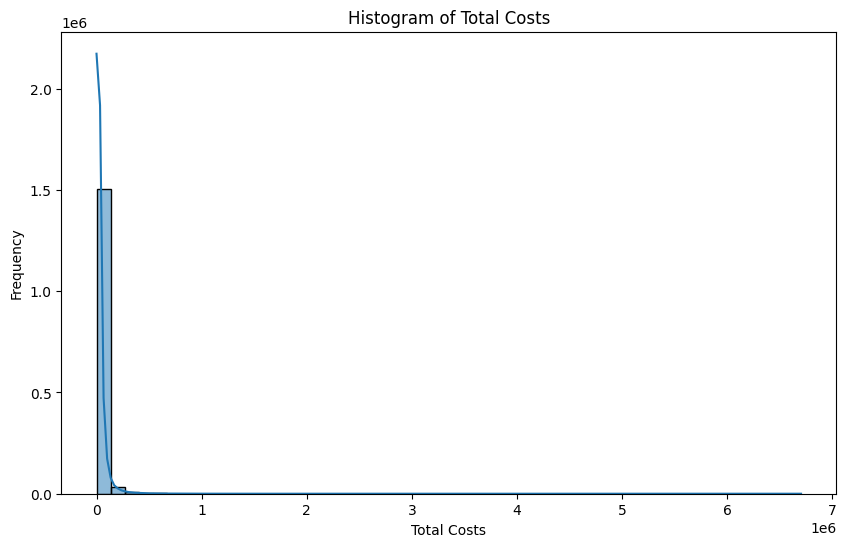

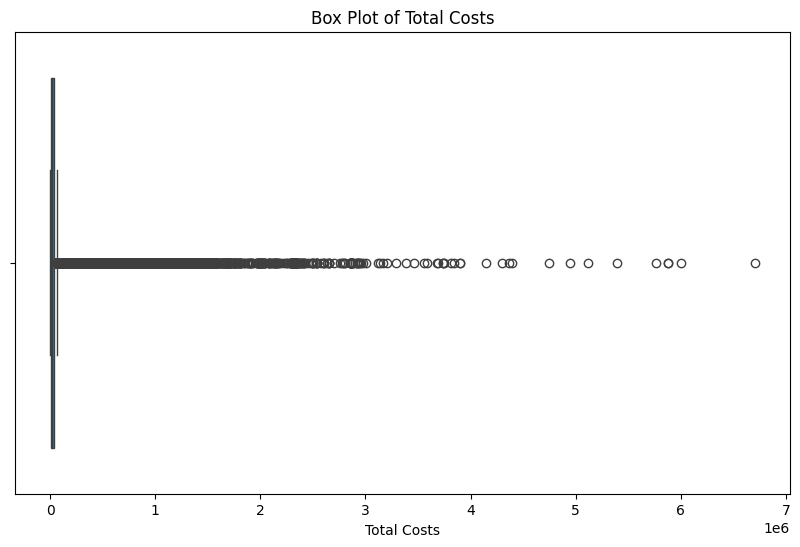

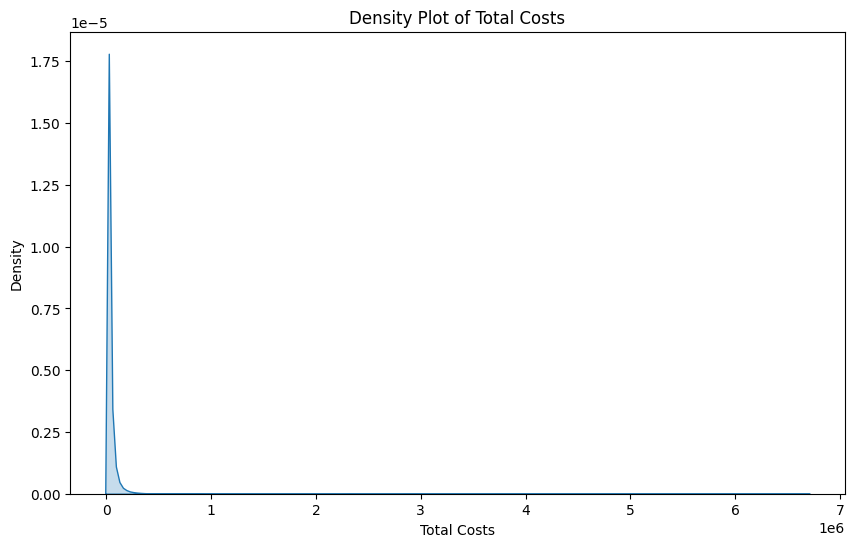

In [32]:
# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['Total Costs'], bins=50, kde=True)
plt.title('Histogram of Total Costs')
plt.xlabel('Total Costs')
plt.ylabel('Frequency')
plt.show()

# Plot box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Total Costs'])
plt.title('Box Plot of Total Costs')
plt.xlabel('Total Costs')
plt.show()

# Plot density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Total Costs'], fill=True)
plt.title('Density Plot of Total Costs')
plt.xlabel('Total Costs')
plt.ylabel('Density')
plt.show()

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1548575 entries, 0 to 1548574
Data columns (total 28 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   Health Service Area                  1548575 non-null  object 
 1   Hospital County                      1548575 non-null  object 
 2   Operating Certificate Number         1548575 non-null  float64
 3   Permanent Facility Id                1548575 non-null  float64
 4   Facility Name                        1548575 non-null  object 
 5   Age Group                            1548575 non-null  object 
 6   Gender                               1548575 non-null  object 
 7   Race                                 1548575 non-null  object 
 8   Ethnicity                            1548575 non-null  object 
 9   Length of Stay                       1548575 non-null  object 
 10  Type of Admission                    1548575 non-null  object 
 11